# Predicting the SOH of Batteries Using deep learning

## Import Library

In [121]:
import argparse
import datetime
import logging
import os
from itertools import cycle, zip_longest

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from torcheval.metrics import R2Score

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cpu


## Select the feature, loading data function

In [122]:
# Assign the training feature in "attribs"
attribs = ['cycle', 'voltage_measured', 'current_measured',  
               'temperature_measured', 'current_load', 'voltage_load', "time"]
fn = len(attribs) # fn is used to count the input neurons of the neural network.

In [123]:
def load_data(battery, err=None): 
    # Construct the file path based on battery and error parameters.
    # If 'err' is provided, use the "LF" variant of the file path.
    if err is not None:
        file_path = f'battery_data/Err_{err}/{battery}_LF.mat'
        battery = battery + "_LF"
    else:
        # Default file path if 'err' is not specified.
        file_path = f'battery_data/{battery}.mat'
    
    # Load data from the .mat file using the specified path.
    mat = loadmat(file_path)
    print(mat.keys())  # Print out keys of the loaded .mat data to check structure.

    # Initialize counters and empty lists to hold dataset and capacity data.
    counter = 0
    dataset = []
    capacity_data = []

    # Iterate over all cycles in the data matrix for the battery.
    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        
        # Process only rows where the 'type' is 'discharge'.
        if row['type'][0] == 'discharge':
            # Retrieve ambient temperature and timestamp.
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(
                int(row['time'][0][0]), int(row['time'][0][1]), int(row['time'][0][2]),
                int(row['time'][0][3]), int(row['time'][0][4])
            ) + datetime.timedelta(seconds=int(row['time'][0][5]))

            # Extract battery data for this cycle.
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            
            # This part can be replaced with 2 iteration function 
            # Iterate through measured data for each time point in the cycle. 
            # corresponding to the TIMESERIES.csv
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                
                # Append all relevant information for this time point in the dataset.
                dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                voltage_measured, current_measured, temperature_measured,
                                current_load, voltage_load, time])
            
            
            # corresponding to the CYCLE_DATA.csv
            # Append summarized cycle information for capacity data.
            capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
            
            # Increment the cycle counter.
            counter = counter + 1
   
    # Return dataset and capacity data as DataFrames for easier manipulation.
    return [pd.DataFrame(data=dataset,
                        columns=['cycle', 'ambient_temperature', 'date_time',
                                'capacity', 'voltage_measured', 'current_measured', 
                                'temperature_measured', 'current_load', 
                                'voltage_load', 'time']),
            pd.DataFrame(data=capacity_data,
                        columns=['cycle', 'ambient_temperature', 'date_time', 'capacity'])]


Data analysis helper function

In [124]:
def get_logger(log_name='log.txt'):
    logger = logging.getLogger('mylogger')
    logger.setLevel(level=logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - function:%(funcName)s - %(levelname)s - %(message)s',datefmt='%Y-%m-%d %H:%M')

    if log_name is not None:
        handler = logging.FileHandler(log_name)
        handler.setLevel(logging.DEBUG)
        handler.setFormatter(formatter)
        logger.addHandler(handler)

    return logger

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def eval_metrix(true_label,pred_label):
    MAE = metrics.mean_absolute_error(true_label,pred_label)
    MAPE = metrics.mean_absolute_percentage_error(true_label,pred_label)
    RMSE = np.sqrt(metrics.mean_squared_error(true_label,pred_label))
    R_squared = metrics.r2_score(true_label, pred_label)   


    return [MAE,MAPE,R_squared,RMSE]

def write_to_txt(txt_name,txt):
    with open(txt_name,'a') as f:
        f.write(txt)
        f.write('\n')



## Neural networks

1. MLP (Multi-Layer Perceptron)

In [125]:
class Sin(nn.Module):
    """Sine activation function as a custom nn.Module."""
    def forward(self, x):
        return torch.sin(x)


class MLP(nn.Module):
    """Multi-Layer Perceptron with sinusoidal activation."""
    def __init__(self, input_dim=7, output_dim=1, layers_num=4, hidden_dim=50, dropout=0.2):
        super(MLP, self).__init__()
        assert layers_num >= 2, "layers_num must be greater than or equal to 2"
        
        layers = []
        for i in range(layers_num):
            if i == 0:
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(Sin())
            elif i == layers_num - 1:
                layers.append(nn.Linear(hidden_dim, output_dim))
            else:
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(Sin())
                layers.append(nn.Dropout(p=dropout))
        
        self.net = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Xavier initialization."""
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        """Forward pass through the MLP."""
        return self.net(x)


2. CNN (Convolutional Neural Network)


In [126]:
class CNN(nn.Module):
    """Basic 1D CNN for regression tasks."""
    def __init__(self, input_dim=fn):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=24, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(24),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv1d(in_channels=24, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU()
        )
        self.fc = None  # Fully connected layer will be dynamically set

    def forward(self, x):
        """Forward pass through the CNN."""
        N, L = x.shape[0], x.shape[1]
        x = x.view(N, 1, L)  # Reshape for 1D convolution
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(N, -1)  # Flatten features
        if self.fc is None or self.fc.in_features != x.shape[1]:
            self.fc = nn.Linear(x.shape[1], 1).to(x.device)  # Dynamically set fc input size
        out = self.fc(x)
        return out.view(N, 1)


3. LSTM (Long Short-Term Memory)

In [127]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=7, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(50, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        N, L = x.shape[0], x.shape[1]
        x = x.view(N, 1, L)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.view(N, 1)

4. TransformerRegressor

In [128]:
class TransformerRegressor(nn.Module):
    """Transformer-based regression model."""
    def __init__(self, num_features=fn, d_model=64, nhead=4, num_layers=3):
        super(TransformerRegressor, self).__init__()
        self.input_layer = nn.Linear(num_features, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 1, d_model))
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        """Forward pass through the Transformer."""
        x = self.input_layer(x).unsqueeze(1)
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = x.permute(1, 0, 2)  # (seq_length, batch_size, d_model)
        x = self.transformer_encoder(x).mean(dim=0)
        return self.fc(x)


5. AttentionNetwork

In [129]:
class AttentionNetwork(nn.Module):
    """Attention-based regression model."""
    def __init__(self, num_features=fn, hidden_dim=64):
        super(AttentionNetwork, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.attention_layer = nn.Linear(hidden_dim, 1)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """Forward pass with attention mechanism."""
        x = torch.relu(self.fc1(x))
        attention_weights = torch.sigmoid(self.attention_layer(x))
        x = x * attention_weights
        return self.fc2(x)


## Baseline

The BASE class defines a baseline framework for training, validation, and testing a model with functionality for monitoring metrics and implementing early stopping. Below is the code with key sections explained in brief comments.

In [130]:
class BASE():
    def __init__(self, model, train_loader, valid_loader, test_loader, args):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.args = args
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader

        self.save_dir = args.save_folder
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        self.epochs = args.epochs
        self.logger = get_logger(os.path.join(args.save_folder, args.log_dir))

        self.loss_meter = AverageMeter()
        self.loss_func = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=args.warmup_lr)
        self.scheduler = torch.optim.Adam(self.model.parameters(), lr=args.lr)
        self.Bestmodel_R_squared = []
        self.Bestmodel_MAE = []
        self.Bestmodel_MAPE = []
        self.Bestmodel_RMSE = []
        
        # Updated paths
        self.train_path = os.path.join(self.save_dir, "true_label.npy")
        self.pred_path = os.path.join(self.save_dir, "pred_label.npy")

    def clear_logger(self):
        self.logger.removeHandler(self.logger.handlers[0])
        self.logger.handlers.clear()

    def train_one_epoch(self, epoch):
        self.model.train()
        self.loss_meter.reset()
        for (x1, y1) in self.train_loader:
            x1 = x1.to(self.device)
            y1 = y1.to(self.device)

            y_pred = self.model(x1)
            loss = self.loss_func(y_pred, y1)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.loss_meter.update(loss.item())
        return self.loss_meter.avg

    def valid(self, epoch):
        self.model.eval()
        self.loss_meter.reset()
        with torch.no_grad():
            for (x1, y1) in self.valid_loader:
                x1 = x1.to(self.device)
                y1 = y1.to(self.device)

                y_pred = self.model(x1)
                loss = self.loss_func(y_pred, y1)
                self.loss_meter.update(loss.item())
        return self.loss_meter.avg

    def test(self):
        self.model.eval()
        self.loss_meter.reset()
        true_label = []
        pred_label = []
        with torch.no_grad():
            for (x1, y1) in self.test_loader:
                x1 = x1.to(self.device)
                y_pred = self.model(x1)

                true_label.append(y1.cpu().detach().numpy())
                pred_label.append(y_pred.cpu().detach().numpy())

        # Concatenate and save labels
        true_label = np.concatenate(true_label, axis=0)
        pred_label = np.concatenate(pred_label, axis=0)
        
        # Save to defined paths
        np.save(self.train_path, true_label)
        np.save(self.pred_path, pred_label)

        return true_label, pred_label, self.train_path, self.pred_path

    def train(self):
        self.Bestmodel_R_squared.clear()
        self.Bestmodel_MAE.clear()
        self.Bestmodel_MAPE.clear()
        self.Bestmodel_RMSE.clear()
        min_loss = 10
        early_stop = 0
        for epoch in range(1, self.epochs + 1):
            early_stop += 1
            train_loss = self.train_one_epoch(epoch)
            current_lr = self.scheduler.step()
            valid_loss = self.valid(epoch)

            if valid_loss < min_loss and self.test_loader is not None:
                min_loss = valid_loss
                true_label, pred_label, self.train_path, self.pred_path = self.test()
                [MAE, MAPE, MSE, RMSE] = eval_metrix(pred_label, true_label)
                self.Bestmodel_R_squared.append(MSE)
                self.Bestmodel_MAE.append(MAE)
                self.Bestmodel_MAPE.append(MAPE)
                self.Bestmodel_RMSE.append(RMSE)
                early_stop = 0
            if early_stop > self.args.early_stop:
                break
        self.clear_logger()


## Data-processing
1. Randomly select the test data (several per each cycle)
2. Random select and Split the rest of the HF dataset and LF dataset according to the requirements
3. Match the dataset with labels
4. Transfer the dataset and label to Dataloader to be trined on GPU

Assistant function for data matching 

In [131]:
def match(dataset, capacity):
    # Define columns to match on: 'cycle' and 'capacity'.
    attrib = ['cycle', 'capacity']
    dis_ele = capacity[attrib].copy()

    # Calculate SOH (State of Health) as a percentage of initial capacity.
    initial_capacity = dis_ele['capacity'].iloc[0]
    dis_ele['SOH'] = dis_ele['capacity'] / initial_capacity
    capacity['SOH'] = dis_ele['SOH']

    # Initialize lists for Label and Cycle.
    Label = []
    Cycle = []
    
    # Iterate over each row in dataset and match cycles with capacity data.
    for idx, row in dataset.iterrows():
        matched_row = capacity[capacity['cycle'] == row['cycle']]
        
        # If a match is found, append the corresponding SOH to Label.
        if not matched_row.empty:
            Label.append(matched_row['SOH'].values[0])
            Cycle.append(row['cycle'])
        else:
            # If no match, append None to indicate missing data.
            Label.append(None)
            Cycle.append(None)
    
    # Convert matched data to DataFrame for easy access.
    Label_df = pd.DataFrame({'cycle': Cycle, 'SOH': Label})

    return Label_df

#Normalize features exclude others 
def normalize(data, exclude_columns):
    """
    Applies Min-Max scaling to DataFrame features, excluding specified columns.

    Args:
        data (pd.DataFrame): Input data with features and columns to exclude.
        exclude_columns (str or list): Name(s) of column(s) to exclude from scaling.

    Returns:
        tuple: (pd.DataFrame, object)
            - normalized_dataset: DataFrame with normalized features and excluded columns.
            - scaler: The fitted MinMaxScaler object.
    """
    if isinstance(exclude_columns, str):
        exclude_columns = [exclude_columns] # Ensure it's a list

    excluded_data_list = []
    features_to_scale = data.columns.tolist()
    for col in exclude_columns:
        if col in data.columns:
            excluded_data_list.append(data[[col]].reset_index(drop=True))
            if col in features_to_scale: # Prevent error if col somehow isn't in list
                 features_to_scale.remove(col)
        else:
             print(f"Warning: Exclude column '{col}' not found in data during normalization.")

    features_data = data[features_to_scale]
    features_data = features_data.apply(pd.to_numeric, errors='coerce')
    if features_data.isnull().any().any():
        print("Warning: Non-numeric data found and converted to NaN during normalization prep. Consider handling NaNs.")

    scaler = MinMaxScaler(feature_range=(0, 1))
    # Ensure data is float before scaling if NaNs were handled or types were mixed
    features_data = features_data.astype(float)
    normalized_features = scaler.fit_transform(features_data)

    normalized_dataset = pd.DataFrame(normalized_features, columns=features_data.columns)

    for df_excluded in excluded_data_list:
        normalized_dataset[df_excluded.columns[0]] = df_excluded

    # Attempt to restore original column order
    try:
        original_cols_in_norm = [col for col in data.columns if col in normalized_dataset.columns]
        normalized_dataset = normalized_dataset[original_cols_in_norm]
    except Exception as e:
        print(f"Could not fully restore original column order: {e}")
        pass

    return normalized_dataset, scaler
def Pre_diff(x, y):
    # Convert x to numpy array if it's a Pandas DataFrame or Series
    if isinstance(x, (pd.DataFrame, pd.Series)):
        x = x.values
    # Convert y to numpy array if it's a Pandas DataFrame or Series
    if isinstance(y, (pd.DataFrame, pd.Series)): # Modified check
        y = y.values

    # Ensure they are numpy arrays before converting to tensor
    # (Handles cases where input might already be numpy but allows conversion if needed)
    x = np.asarray(x)
    y = np.asarray(y)

    tensor_X = torch.from_numpy(x).float()
    # Ensure y is treated correctly even if it was originally 1D
    tensor_Y = torch.from_numpy(y).float().view(-1, 1)
    dataset = TensorDataset(tensor_X, tensor_Y)
    return dataset

Data_processing function

In [132]:
def create_dataloaderB(dataset, split_ratios=(0.8, 0.2), batch_size=64, type='regression'):
    """
    Create train and validation data loaders from the given dataset.

    Args:
        dataset: The input dataset for training and validation.
        split_ratios (tuple): Ratios to split the dataset (train_ratio, valid_ratio).
        batch_size (int): Batch size for data loaders.
        type (str): Task type, typically "regression".

    Returns:
        train_loader: DataLoader for training data.
        valid_loader: DataLoader for validation data.
    """
    assert sum(split_ratios) == 1

    train_ratio, valid_ratio = split_ratios    
    # Split the dataset into train and validation sets
    train_size = int(train_ratio * len(dataset))
    valid_size = int(valid_ratio * len(dataset))
 
    if type == 'regression':
        train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, valid_loader


def Data_processing(battery_code, err, total_data, test_size, train_ratio, valid_ratio, type):
    """
    Load and preprocess battery data for training, validation, and testing.

    Args:
        battery_code (str): Code of the battery dataset to load.
        err (float): Error tolerance level for data loading.
        total_data (int): Total number of data points in the training set.
        test_size (int): Number of test points per cycle.
        train_ratio (float): Proportion of data used for training.
        valid_ratio (float): Proportion of data used for validation.
        type (str): Task type, typically "regression".

    Returns:
        train_loader: DataLoader for training data.
        valid_loader: DataLoader for validation data.
        test_loader: DataLoader for test data.
        data_capacity: Capacity information for training data.
        data_label: Label information for training data.
    """
    # Load the entire dataset and capacity information
    BS_dataset, BS_capacity = load_data(battery_code) 

    # Extract test dataset by selecting test_size points per cycle
    Test_dataset = pd.DataFrame(columns=BS_dataset.columns)
    for cycle_index, group in BS_dataset.groupby('cycle'):
        test_points = group.sample(n=test_size, random_state=42)
        Test_dataset = pd.concat([Test_dataset, test_points])
        
    # Ensure data types match and sort the test dataset
    for col in Test_dataset.columns:
        Test_dataset[col] = Test_dataset[col].astype(BS_dataset[col].dtype)

    Test_dataset = Test_dataset.sort_values(by=['cycle', 'time']).reset_index(drop=True)
    Test_label = match(Test_dataset, BS_capacity)
    Test_train, _ = normalize(Test_dataset[attribs], 'cycle')
    print(f"Test set size: {len(Test_train)}")

    # Create DataLoader for test data
    test_loader = DataLoader(
        Pre_diff(Test_train, Test_label["SOH"].to_numpy()), 
        batch_size=64, 
        shuffle=False
    )

    # Remove test samples from the original dataset and sort it
    BS_dataset = BS_dataset.drop(Test_dataset.index)
    BS_dataset = BS_dataset.sort_values(by=['cycle', 'time']).reset_index(drop=True)

    # Sample the required number of data points for training
    if type == "regression":
        BS_dataset = BS_dataset.sample(n=total_data)
        BS_dataset = BS_dataset.sort_values(by=['cycle', 'time']).reset_index(drop=True)
        BS_capacity = BS_capacity.merge(BS_dataset[['cycle']], on='cycle', how='inner')

    # Compute labels and normalize training dataset
    BS_label = match(BS_dataset, BS_capacity)
    BS_train, _ = normalize(BS_dataset[attribs], 'cycle')
    print(f"The total size of the dataset for the baseline task is: {len(BS_train)}")

    # Create DataLoaders for training and validation sets
    train_loader, valid_loader = create_dataloaderB(
        Pre_diff(BS_train, BS_label["SOH"].to_numpy()),
        split_ratios=(train_ratio, valid_ratio),
        batch_size=64,
        type=type
    )

    return train_loader, valid_loader, test_loader, BS_capacity, BS_label


In [133]:
def preprocess_snl_lfp_data_revised(
    timeseries_filepath,
    cycle_data_filepath,
    # --- SOH Calculation ---
    capacity_col_cycle = 'Discharge_Capacity (Ah)', # Column for cycle capacity
    initial_capacity_method='first_cycle', # 'first_cycle', 'max', 'provided'
    initial_capacity_value=None            # Value if method is 'provided'
    ):
    """
    Preprocesses SNL LFP battery data for models trained on specific .mat features.
    Handles missing 'current_load', 'voltage_load' and calculates relative time.

    Args:
        timeseries_filepath (str): Path to the *_timeseries.csv file.
        cycle_data_filepath (str): Path to the *_cycle_data.csv file.
        capacity_col_cycle (str): Column name for capacity in cycle_data_filepath.
        initial_capacity_method (str): How to find initial capacity ('first_cycle', 'max', 'provided').
        initial_capacity_value (float, optional): The initial capacity value if method is 'provided'.

    Returns:
        tuple: (pd.DataFrame, pd.Series)
            - normalized_features_df: DataFrame with normalized features renamed to match
                                      original attribs where possible (excluding load features).
                                      Columns: ['cycle', 'voltage_measured', 'current_measured',
                                               'temperature_measured', 'time']
            - soh_labels: Series containing the SOH value aligned with normalized_features_df rows.
        Returns (None, None) if processing fails.
    """
    try:
        # --- 1. Load Data ---
        print(f"Loading detailed data from: {timeseries_filepath}")
        detailed_data = pd.read_csv(timeseries_filepath)

        print(f"Loading cycle summary from: {cycle_data_filepath}")
        cycle_summary = pd.read_csv(cycle_data_filepath)

        # --- Define Original and Available Features ---
        # Original features expected by the model (from attribs)
        original_features = ['voltage_measured', 'current_measured',
                             'temperature_measured', 'current_load',
                             'voltage_load', 'time']
        # Features available in the SNL CSV data mapped to original concepts
        snl_feature_map = {
            'Voltage (V)': 'voltage_measured',
            'Current (A)': 'current_measured',
            'Cell_Temperature (C)': 'temperature_measured',
            'Test_Time (s)': 'time' # Will be replaced by calculated relative time
        }
        available_snl_cols = list(snl_feature_map.keys())

        # --- 2. Validate Columns ---
        required_ts_cols = ['Cycle_Index', 'Test_Time (s)'] + available_snl_cols
        for col in required_ts_cols:
            if col not in detailed_data.columns:
                 # Check specifically for Cell_Temperature as it might be missing sometimes
                 if col == 'Cell_Temperature (C)':
                     print(f"Warning: Column '{col}' not found in {timeseries_filepath}. Temperature feature will be skipped.")
                     available_snl_cols.remove(col) # Remove from list if not found
                 else:
                     raise ValueError(f"Required column '{col}' not found in {timeseries_filepath}")

        required_cycle_cols = ['Cycle_Index', capacity_col_cycle]
        for col in required_cycle_cols:
            if col not in cycle_summary.columns:
                raise ValueError(f"Required column '{col}' not found in {cycle_data_filepath}")

        # --- 3. Calculate Relative Time ---
        print("Calculating relative time within each cycle...")
        # Sort data first to ensure min() gets the start time
        detailed_data = detailed_data.sort_values(by=['Cycle_Index', 'Test_Time (s)']).reset_index(drop=True)
        # Calculate time difference from the start of each cycle
        detailed_data['relative_time'] = detailed_data.groupby('Cycle_Index')['Test_Time (s)'].transform(lambda x: x - x.min())

        # Update the map and available columns to use relative_time instead of Test_Time (s)
        if 'Test_Time (s)' in available_snl_cols:
            available_snl_cols.remove('Test_Time (s)')
        available_snl_cols.append('relative_time') # Add the new relative time column
        snl_feature_map['relative_time'] = 'time' # Map it to the original 'time' feature

        # --- 4. Prepare and Calculate SOH from Cycle Data ---
        # (Same SOH calculation logic as before)
        capacity_data = cycle_summary[['Cycle_Index', capacity_col_cycle]].copy()
        capacity_data = capacity_data.rename(columns={capacity_col_cycle: 'capacity'})
        capacity_data = capacity_data.sort_values(by='Cycle_Index').reset_index(drop=True)
        capacity_data = capacity_data.drop_duplicates(subset=['Cycle_Index'], keep='first')

        initial_capacity = None
        first_cycle_capacity = capacity_data[capacity_data['Cycle_Index'] == 1.0]['capacity']

        if initial_capacity_method == 'first_cycle':
             if not first_cycle_capacity.empty:
                 initial_capacity = first_cycle_capacity.iloc[0]
             else:
                 print("Warning: Cycle_Index 1.0 not found for 'first_cycle' method. Trying minimum cycle index.")
                 if not capacity_data.empty:
                      initial_capacity = capacity_data.iloc[0]['capacity']
                 else:
                      raise ValueError("Capacity data is empty, cannot determine initial capacity.")

        elif initial_capacity_method == 'max':
            initial_capacity = capacity_data['capacity'].max()
        elif initial_capacity_method == 'provided':
            if initial_capacity_value is None:
                raise ValueError("initial_capacity_value must be provided if method is 'provided'")
            initial_capacity = initial_capacity_value
        else:
            raise ValueError(f"Unknown initial_capacity_method: {initial_capacity_method}")

        if initial_capacity is None or initial_capacity <= 0:
            raise ValueError(f"Could not determine a valid initial capacity (found: {initial_capacity})")

        print(f"Using Initial Capacity for SOH calculation: {initial_capacity:.4f}")
        capacity_data['SOH'] = capacity_data['capacity'] / initial_capacity


        # --- 5. Prepare Time-Series Features and Merge SOH ---
        # Select only the available features + Cycle_Index
        features_to_keep = ['Cycle_Index'] + available_snl_cols
        features_df = detailed_data[features_to_keep].copy()

        # Merge SOH information based on cycle number
        merged_data = pd.merge(features_df, capacity_data[['Cycle_Index', 'SOH']], on='Cycle_Index', how='left')

        # Handle potential NaNs from merge or if SOH calc failed for some cycles
        rows_before_drop = len(merged_data)
        merged_data.dropna(subset=['SOH'], inplace=True)
        rows_after_drop = len(merged_data)
        if rows_before_drop > rows_after_drop:
             print(f"Dropped {rows_before_drop - rows_after_drop} rows with missing SOH.")

        if merged_data.empty:
            print("Error: No data remaining after merging SOH. Check cycle indices match.")
            return None, None

        # --- 6. Normalize Available Features ---
        # The 'normalize' function expects the column to exclude ('Cycle_Index')
        data_for_norm = merged_data[['Cycle_Index'] + available_snl_cols] # Use SNL names here

        print(f"Normalizing features (SNL Names): {available_snl_cols}")
        normalized_data_snl_names, scaler = normalize(data_for_norm, exclude_columns='Cycle_Index')

        # --- 7. Rename Columns to Match Original Attribs ---
        # Rename columns in the final output df to match original 'attribs' where possible
        final_col_map = {snl_col: target_name for snl_col, target_name in snl_feature_map.items() if snl_col in normalized_data_snl_names.columns}
        # Also handle the cycle index column
        final_col_map['Cycle_Index'] = 'cycle'

        normalized_data_renamed = normalized_data_snl_names.rename(columns=final_col_map)

        # Define the final expected column order based on original attribs (excluding missing ones)
        final_ordered_cols = ['cycle'] + [col for col in ['voltage_measured', 'current_measured', 'temperature_measured', 'time'] if col in normalized_data_renamed.columns]
        normalized_features_df = normalized_data_renamed[final_ordered_cols]

        print(f"Final feature columns: {normalized_features_df.columns.tolist()}")
        print("Note: 'current_load' and 'voltage_load' features are excluded as they are not present in the source CSV.")

        # --- 8. Prepare Output ---
        # Use the index of the final df to get aligned SOH labels
        soh_labels = merged_data.loc[normalized_features_df.index, 'SOH']

        # Final sanity check for alignment
        if len(normalized_features_df) != len(soh_labels):
            print("Error: Length mismatch between final features and SOH labels.")
            return None, None

        print(f"Preprocessing complete. Processed {len(normalized_features_df)} data points.")
        return normalized_features_df, soh_labels

    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        return None, None
    except ValueError as e:
        print(f"Error: Data processing error - {e}")
        return None, None
    except KeyError as e:
        print(f"Error: Column not found - {e}. Check column names in files and arguments.")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None


# --- Example Usage ---
# ts_file = 'path/to/your/SNL_18650_LFP_15C_0-100_0.5-1C_a_timeseries.csv'
# cycle_file = 'path/to/your/SNL_18650_LFP_15C_0-100_0.5-1C_a_cycle_data.csv'

# processed_features, soh = preprocess_snl_lfp_data_revised(ts_file, cycle_file)

# if processed_features is not None and soh is not None:
#     print("\nProcessed Features Head:")
#     print(processed_features.head())
#     print("\nSOH Labels Head:")
#     print(soh.head())
#     print(f"\nShapes: Features={processed_features.shape}, SOH={soh.shape}")

    # Expected output columns in processed_features:
    # ['cycle', 'voltage_measured', 'current_measured', 'temperature_measured', 'time']

    # You can now feed 'processed_features' and 'soh' into Pre_diff etc.
    # tensor_dataset = Pre_diff(processed_features, soh)

## Evaluation, plot and save

Display the evaluation matrics and save to xlsx files

In [134]:
def plot_soh_comparison(true_label_path, pred_label_path, hf_capacity, figsize=(12, 8), dpi=600):
    """
    Plot comparison between true and predicted SOH values over cycles.

    Args:
        true_label_path (str): Path to the true SOH label data (numpy file).
        pred_label_path (str): Path to the predicted SOH label data (numpy file).
        hf_capacity (pd.DataFrame): DataFrame containing cycle and SOH information.
        figsize (tuple): Figure size for plotting.
        dpi (int): Dots per inch for figure resolution.
    """
    # Load true and predicted labels
    true_label = np.load(true_label_path)
    pred_label = np.load(pred_label_path)
    
    # Flatten arrays for plotting
    tl = true_label.flatten()
    pl = pred_label.flatten()

    tl_avg = [(tl[i] + tl[i+1]) / 2 for i in range(0, len(tl), 2)]
    pl_avg = [(pl[i] + pl[i+1]) / 2 for i in range(0, len(pl), 2)]

    cycles = np.arange(1, len(tl_avg) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(cycles, tl_avg, marker='o', linestyle='--', color='blue', label='True SOH (tl)')
    plt.plot(cycles, pl_avg, marker='x', linestyle='-', color='red', label='Predicted SOH (pl)')
    plt.xlabel('Cycle Index')
    plt.ylabel('SOH')
    plt.title('Comparison of True and Predicted SOH')
    plt.legend()
    plt.grid(True)
    plt.show()


In [135]:
def save_to_excel(me_matrix, n, m, Way, data_name, err, data_count, test_size):
    """
    Save performance metrics to an Excel file.

    Args:
        me_matrix (list): Matrix containing performance metrics for different runs.
        n (int): Number of initializations.
        m (int): Number of repetitions per initialization.
        Way (str): Model architecture used.
        data_name (str): Dataset name.
        err (float): Noise level applied during preprocessing.
        data_count (int): Total number of training data points.
        test_size (int): Number of test points per cycle.
    """
    data = {
        'n': [],
        'm': [],
        'R Squared': [],
        'MAE': [],
        'MAPE': [],
        'RMSE': []
    }

    # Collect metrics for each repetition
    for init_index, init_me_list in enumerate(me_matrix):
        for repeat_index in range(m):
            data['n'].append(init_index + 1)
            data['m'].append(repeat_index + 1)
            me = init_me_list[repeat_index]
            data['R Squared'].append(me['R Squared'])
            data['MAE'].append(me['MAE'])
            data['MAPE'].append(me['MAPE'])
            data['RMSE'].append(me['RMSE'])

    # Compute and save average metrics for each initialization
    for init_index, init_me_list in enumerate(me_matrix):
        avg_me = [sum(item[key] for item in init_me_list) / len(init_me_list) for key in init_me_list[0].keys()]
        data['n'].append(init_index + 1)
        data['m'].append('Ave')
        data['R Squared'].append(avg_me[0])
        data['MAE'].append(avg_me[1])
        data['MAPE'].append(avg_me[2])
        data['RMSE'].append(avg_me[3])

    # Compute overall average metrics
    all_rsquared = [me['R Squared'] for init_me_list in me_matrix for me in init_me_list]
    all_mae = [me['MAE'] for init_me_list in me_matrix for me in init_me_list]
    all_mape = [me['MAPE'] for init_me_list in me_matrix for me in init_me_list]
    all_rmse = [me['RMSE'] for init_me_list in me_matrix for me in init_me_list]

    overall_average_me = {
        'R Squared': sum(all_rsquared) / len(all_rsquared),
        'MAE': sum(all_mae) / len(all_mae),
        'MAPE': sum(all_mape) / len(all_mape),
        'RMSE': sum(all_rmse) / len(all_rmse)
    }

    data['n'].append('Ave')
    data['m'].append('Ave')
    data['R Squared'].append(overall_average_me['R Squared'])
    data['MAE'].append(overall_average_me['MAE'])
    data['MAPE'].append(overall_average_me['MAPE'])
    data['RMSE'].append(overall_average_me['RMSE'])

    # Save data to Excel
    df = pd.DataFrame(data)
    save_path = f"Final_result/Benchmark/{Way}/"
    file_name = f"{data_name}_{err}_{data_count}_{test_size}.xlsx"

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    df.to_excel(os.path.join(save_path, file_name), index=False)


def print_evaluation_matrix(me_matrix, n, m, Way, data_name, err, data_count, test_size, plot_switch, 
                            true_label_path=None, pred_label_path=None, hf_capacity=None):
    """
    Print and visualize the evaluation matrix for training results.

    Args:
        me_matrix (list): Performance metrics matrix for all repetitions.
        n (int): Number of data initializations.
        m (int): Number of repetitions per initialization.
        Way (str): Model architecture used.
        data_name (str): Dataset name.
        err (float): Noise level applied.
        data_count (int): Total training data points used.
        test_size (int): Number of test points per cycle.
        plot_switch (str): Set to 'ON' to enable result plotting.
        true_label_path (str): Path to the true label for plotting.
        pred_label_path (str): Path to the predicted label for plotting.
        hf_capacity (pd.DataFrame): Cycle and true SOH data.
    """
    for init_index, init_me_list in enumerate(me_matrix):
        if plot_switch == "ON":
            print(f"Data Initialization {init_index+1} Results:")
            for repeat_index, me in enumerate(init_me_list):
                print(f"Repeat {repeat_index+1}: R Squared: {me['R Squared']:.8f}, "
                      f"MAE: {me['MAE']:.6f}, "
                      f"MAPE: {me['MAPE']:.6f}, "
                      f"RMSE: {me['RMSE']:.6f}")

    # Compute and print average performance for each initialization
    average_me_matrix = [[sum(item[key] for item in init_me_list) / len(init_me_list) for key in init_me_list[0].keys()] for init_me_list in me_matrix]
    for init_index, avg_me in enumerate(average_me_matrix):
        if plot_switch == "ON":
            print(f"Average Performance for Data Initialization {init_index+1}:")
            print(f"R Squared: {avg_me[0]:.8f}, MAE: {avg_me[1]:.6f}, MAPE: {avg_me[2]:.6f}, RMSE: {avg_me[3]:.6f}")

    # Compute and print overall average performance
    all_rsquared = [me['R Squared'] for init_me_list in me_matrix for me in init_me_list]
    all_mae = [me['MAE'] for init_me_list in me_matrix for me in init_me_list]
    all_mape = [me['MAPE'] for init_me_list in me_matrix for me in init_me_list]
    all_rmse = [me['RMSE'] for init_me_list in me_matrix for me in init_me_list]

    overall_average_me = {
        'R Squared': sum(all_rsquared) / len(all_rsquared),
        'MAE': sum(all_mae) / len(all_mae),
        'MAPE': sum(all_mape) / len(all_mape),
        'RMSE': sum(all_rmse) / len(all_rmse)
    }

    print("Overall Average Model Performance:")
    print(f"R Squared: {overall_average_me['R Squared']:.8f}, "
          f"MAE: {overall_average_me['MAE']:.6f}, "
          f"MAPE: {overall_average_me['MAPE']:.6f}, "
          f"RMSE: {overall_average_me['RMSE']:.6f}")

    # Plot the SOH comparison if plot switch is enabled
    if plot_switch == "ON" and true_label_path and pred_label_path and hf_capacity is not None:
        plot_soh_comparison(true_label_path, pred_label_path, hf_capacity)


plot function, using when needed

## Main

Train ()
getargs

In [136]:
class ArgsNamespace:
    """Class to create an object for managing hyperparameters."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


def load_model(args):
    """
    Load the specified model based on user input.

    Args:
        args: Hyperparameters and model configurations.

    Returns:
        model: Initialized model instance.
    """
    if args.model == 'MLP':
        model = MLP()
    elif args.model == 'CNN':
        model = CNN()
    elif args.model == 'LSTM':
        model = LSTM()
    elif args.model == 'Trans':
        model = TransformerRegressor()
    elif args.model == 'Atten':
        model = AttentionNetwork()
    else:
        raise ValueError("Unknown model type specified.")
    return model


def get_hyperparams():
    """
    Define hyperparameters for the training process.

    Returns:
        dict: Hyperparameter configuration.
    """
    hyperparams = {
        'epochs': 200,  # Maximum number of training epochs
        'early_stop': 20,  # Early stopping threshold
        'warmup_epochs': 30,  # Number of warmup epochs
        'warmup_lr': 0.005,  # Learning rate during warmup
        'lr': 0.01,  # Learning rate for training

        # Model structure parameters
        'F_layers_num': 3,
        'F_hidden_dim': 25,

        # Directories
        'log_dir': 'text testinglog.txt',
        'save_folder': 'results_base'
    }
    return hyperparams


def Run_task(init_index, m, train_loader, valid_loader, test_loader, me_list, Way):
    """
    Execute the training process with repeated experiments.

    Args:
        init_index (int): Index of the current initialization.
        m (int): Number of experiment repetitions for the current initialization.
        train_loader: Training data loader.
        valid_loader: Validation data loader.
        test_loader: Test data loader.
        me_list (list): List to store performance metrics.
        Way (str): Model architecture ("MLP", "CNN", "LSTM", etc.).
    """

    # Load hyperparameters and initialize arguments
    hyperparams = get_hyperparams()
    args = ArgsNamespace(**hyperparams)
    setattr(args, 'model', Way)  # Set the model type
    
    for repeat_index in range(m):
        # Load and train the model
        model = load_model(args)
        trainer = BASE(model, train_loader, valid_loader, test_loader, args)
        trainer.train()  # Execute training process
        true_label_path = trainer.train_path
        pred_label_path = trainer.pred_path
        # Collect evaluation metrics
        metrics = {
            'R Squared': trainer.Bestmodel_R_squared[-1],
            'MAE': trainer.Bestmodel_MAE[-1],
            'MAPE': trainer.Bestmodel_MAPE[-1],
            'RMSE': trainer.Bestmodel_RMSE[-1]
        }
        me_list.append(metrics)
        print(f"Repetition {init_index+1}, {repeat_index+1} results: R^2={metrics['R Squared']:.4f}, "
              f"MAE={metrics['MAE']:.4f}, MAPE={metrics['MAPE']:.4f}, RMSE={metrics['RMSE']:.4f}")

    return args, true_label_path, pred_label_path


### 3.3.1 Benchmark Testing


--- Processing Dataset: B0005 (Type: mat) ---
Model Type: MLP
  Initialization Run: 1/1
    Loading and processing .mat data...
dict_keys(['__header__', '__version__', '__globals__', 'B0005'])


C:\Users\kench\AppData\Local\Temp\ipykernel_1528\2541505419.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Test_dataset = pd.concat([Test_dataset, test_points])


Test set size: 336
The total size of the dataset for the baseline task is: 1000
    Running task (training/evaluation)...
Repetition 1, 1 results: R^2=0.4811, MAE=0.0613, MAPE=0.0837, RMSE=0.0824
  Generating plot...


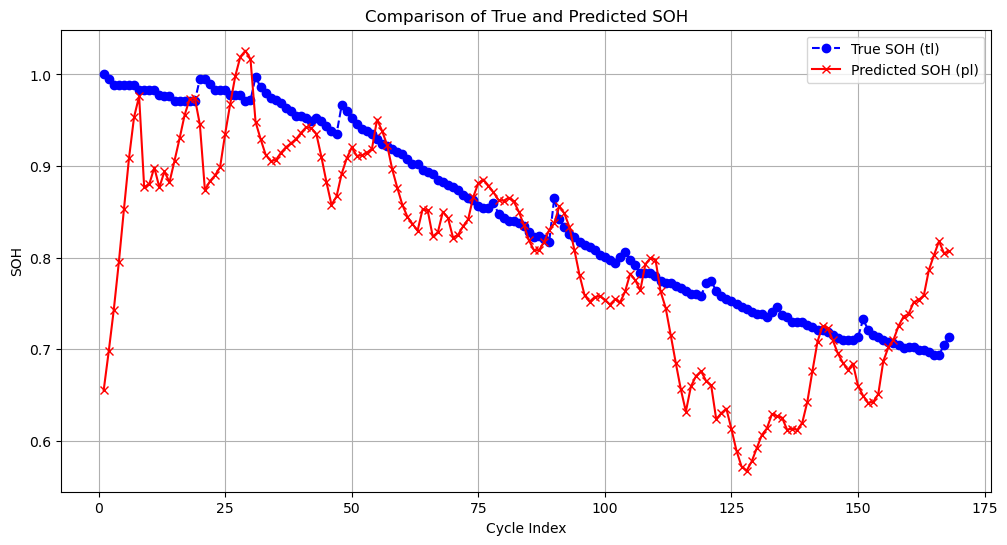

  Printing evaluation matrix...
Data Initialization 1 Results:
Repeat 1: R Squared: 0.48111504, MAE: 0.061279, MAPE: 0.083734, RMSE: 0.082427
Average Performance for Data Initialization 1:
R Squared: 0.48111504, MAE: 0.061279, MAPE: 0.083734, RMSE: 0.082427
Overall Average Model Performance:
R Squared: 0.48111504, MAE: 0.061279, MAPE: 0.083734, RMSE: 0.082427

--- Processing Dataset: B0006 (Type: mat) ---
Model Type: MLP
  Initialization Run: 1/1
    Loading and processing .mat data...
dict_keys(['__header__', '__version__', '__globals__', 'B0006'])


C:\Users\kench\AppData\Local\Temp\ipykernel_1528\2541505419.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Test_dataset = pd.concat([Test_dataset, test_points])


Test set size: 336
The total size of the dataset for the baseline task is: 1000
    Running task (training/evaluation)...
Repetition 1, 1 results: R^2=0.7813, MAE=0.0511, MAPE=0.0641, RMSE=0.0567
  Generating plot...


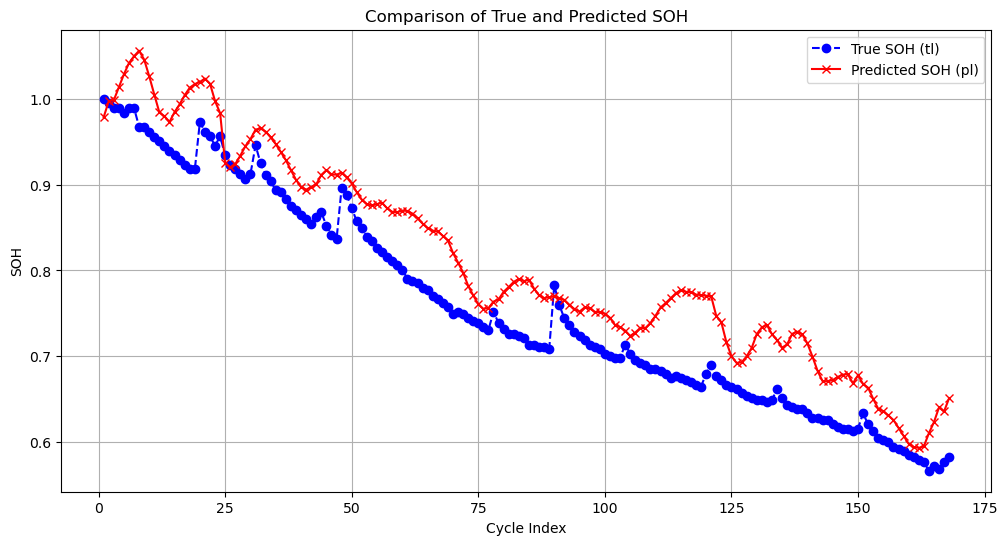

  Printing evaluation matrix...
Data Initialization 1 Results:
Repeat 1: R Squared: 0.78134459, MAE: 0.051081, MAPE: 0.064079, RMSE: 0.056718
Average Performance for Data Initialization 1:
R Squared: 0.78134459, MAE: 0.051081, MAPE: 0.064079, RMSE: 0.056718
Overall Average Model Performance:
R Squared: 0.78134459, MAE: 0.051081, MAPE: 0.064079, RMSE: 0.056718

--- Processing Dataset: SNL_18650_LFP_15C_0-100_0.5-1C_a (Type: csv) ---
Model Type: MLP
  Initialization Run: 1/1
    Loading and processing .csv data...
Loading detailed data from: SNL_LFP/SNL_18650_LFP_15C_0-100_0.5-1C_a_timeseries.csv
Loading cycle summary from: SNL_LFP/SNL_18650_LFP_15C_0-100_0.5-1C_a_cycle_data.csv
Calculating relative time within each cycle...
Using Initial Capacity for SOH calculation: 1.0300
Normalizing features (SNL Names): ['Voltage (V)', 'Current (A)', 'Cell_Temperature (C)', 'relative_time']
Final feature columns: ['cycle', 'voltage_measured', 'current_measured', 'temperature_measured', 'time']
Note:

KeyboardInterrupt: 

In [ ]:
# --- Configuration ---
n = 1  # Number of initialization runs
m = 1  # Number of repetitions for each run
plot_switch = 'ON'  # Set to 'ON' to enable plotting

# --- MODIFIED: Identify dataset types ---
# Use a dictionary or list of tuples to store dataset info and type
datasets_info = [
    {'id': 'B0005', 'type': 'mat', 'noise': 0.02},
    {'id': 'B0006', 'type': 'mat', 'noise': 0.02},
    # Add more .mat datasets as needed
    {
      'id': 'SNL_18650_LFP_15C_0-100_0.5-1C_a', # Base name for SNL files
      'type': 'csv',
      'ts_path': 'SNL_LFP/SNL_18650_LFP_15C_0-100_0.5-1C_a_timeseries.csv',
      'cycle_path': 'SNL_LFP/SNL_18650_LFP_15C_0-100_0.5-1C_a_cycle_data.csv'
    }
    # Add more .csv datasets as needed
]

data_count_mat = 1000  # Data count for .mat sampling (if different logic needed)
test_size_mat = 2      # Test size for .mat sampling

# Define split ratios (can be used for both pipelines if desired)
train_ratio, valid_ratio, test_ratio = 0.7, 0.15, 0.15
batch_size = 64

Ways = ["MLP"]  # Model architectures to evaluate

# --- Main training loop ---
for dataset_info in datasets_info:
    dataset_id = dataset_info['id']
    dataset_type = dataset_info['type']
    print(f"\n--- Processing Dataset: {dataset_id} (Type: {dataset_type}) ---")

    for Way in Ways:
        print(f"Model Type: {Way}")
        me_matrix = []  # Initialize evaluation matrix for each dataset
        # These might be populated differently depending on pipeline
        # Initialize to None; plotting function should handle None if data not available
        final_data_capacity_for_plotting = None
        final_true_label_path = None
        final_pred_label_path = None


        for init_index in range(n):  # Loop through different initial data splits/runs
            print(f"  Initialization Run: {init_index + 1}/{n}")

            train_loader, valid_loader, test_loader = None, None, None
            data_capacity, data_label = None, None # Specific to .mat pipeline output

            # --- Conditional Data Loading and Preprocessing ---
            if dataset_type == 'mat':
                print("    Loading and processing .mat data...")
                noise = dataset_info.get('noise', 0.0) # Get noise if specified for this dataset
                train_loader, valid_loader, test_loader, data_capacity, data_label = Data_processing(
                    dataset_id,
                    err=noise,
                    total_data=data_count_mat, # Use specific count for .mat
                    test_size=test_size_mat,   # Use specific test size for .mat
                    train_ratio=0.8,   # Use defined ratios
                    valid_ratio=0.2,   # Use defined ratios
                    type="regression"
                )
                final_data_capacity_for_plotting = data_capacity # Save for potential plotting

            elif dataset_type == 'csv':
                print("    Loading and processing .csv data...")
                ts_path = dataset_info['ts_path']
                cycle_path = dataset_info['cycle_path']

                # 1. Preprocess CSV data
                processed_features, soh_labels = preprocess_snl_lfp_data_revised(
                    ts_path, cycle_path
                    # Add other relevant args if needed, e.g., initial_capacity_method
                )

                csv_sample_size = 1000
                processed_features_sampled = processed_features.sample(
                    n=csv_sample_size,
                    random_state=42 # Optional: for reproducible sampling
                )
                soh_labels_sampled = soh_labels.loc[processed_features_sampled.index]

                # Use the sampled data for the rest of the process
                processed_features = processed_features_sampled
                soh_labels = soh_labels_sampled
                print(f"    Now using {len(processed_features)} sampled data points.")

                
                print("    Adding dummy columns for 'current_load' and 'voltage_load' with zeros.")
                features_for_tensor['current_load'] = 0.0
                features_for_tensor['voltage_load'] = 0.0

                # Drop 'cycle' column before passing features to Pre_diff
                features_for_tensor = processed_features # .drop(columns=['cycle'])
                
                print("    Adding dummy columns for 'current_load' and 'voltage_load' with zeros.")
                features_for_tensor['current_load'] = 0.0
                features_for_tensor['voltage_load'] = 0.0
                expected_order = ['cycle', 'voltage_measured', 'current_measured', 'temperature_measured', 'current_load', 'voltage_load', 'time']
                # Filter based on columns actually present (in case temp was missing etc)
                cols_to_use = [col for col in expected_order if col in features_for_tensor.columns]
                features_for_tensor = features_for_tensor[cols_to_use]

                tensor_dataset = Pre_diff(features_for_tensor, soh_labels)

                # 3. Split TensorDataset into Train, Validation, Test
                total_size = len(tensor_dataset)
                train_size = int(train_ratio * total_size)
                valid_size = int(valid_ratio * total_size)
                # Ensure test_size calculation avoids rounding errors
                test_size = total_size - train_size - valid_size 
                
                if train_size <= 0 or valid_size <= 0 or test_size <= 0:
                     print(f"Warning: Dataset size {total_size} is too small for split ratios {train_ratio}/{valid_ratio}/{test_ratio}. Skipping run.")
                     continue

                print(f"    Splitting data: Train={train_size}, Valid={valid_size}, Test={test_size}")
                # Use random_split for reproducibility if desired (add generator=torch.Generator().manual_seed(42))
                train_dataset, valid_dataset, test_dataset = random_split(
                    tensor_dataset, [train_size, valid_size, test_size]
                )

                # 4. Create DataLoaders
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                # 5. Handle capacity/label info for downstream tasks if needed
                # 'data_capacity' from the .mat pipeline contained cycle info.
                # We can reconstruct something similar from the cycle_summary if needed for plotting.
                # For now, setting to None. Modify if your plotting/Run_task strictly needs it.
                # Example: Load cycle summary again if needed for plotting capacity vs cycle
                try:
                    cycle_summary_df = pd.read_csv(cycle_path)
                    final_data_capacity_for_plotting = cycle_summary_df[['Cycle_Index', 'Discharge_Capacity (Ah)']].rename(columns={'Cycle_Index':'cycle', 'Discharge_Capacity (Ah)':'capacity'})
                except Exception as e:
                    print(f"Could not load cycle summary for plotting capacity: {e}")
                    final_data_capacity_for_plotting = None
                data_label = None # Original labels not needed separately as they are in loaders

            else:
                print(f"    Unknown dataset type: {dataset_type}. Skipping.")
                continue # Skip to the next initialization run

            # --- Check if loaders were created ---
            if train_loader is None or valid_loader is None or test_loader is None:
                 print("    DataLoaders not created successfully. Skipping run.")
                 continue


            # --- Run Task (Model Training and Evaluation) ---
            print("    Running task (training/evaluation)...")
            me_list = []  # Initialize list for metrics of the current initialization
            # Assuming Run_task takes loaders and returns paths for labels
            try:
                 # Make sure Run_task can handle potentially None capacity/label inputs if needed
                 args, true_label_path, pred_label_path = Run_task(
                     init_index, m, train_loader, valid_loader, test_loader, me_list, Way=Way
                     # Pass other args needed by Run_task
                 )
                 me_matrix.append(me_list)  # Append metrics for this run
                 final_true_label_path = true_label_path # Store paths from the last run
                 final_pred_label_path = pred_label_path
            except Exception as e:
                 print(f"Error during Run_task: {e}")
                 # Decide how to handle error: continue to next init, break, etc.
                 continue


        # --- Post-Run Analysis (after all initializations for a dataset/model) ---
        if not me_matrix:
             print("No metrics were generated for this dataset/model combination.")
             continue # Skip plotting and evaluation printing if no results

        # Use results from the last successful run for plotting
        if plot_switch == "ON":
             print("  Generating plot...")
             if final_true_label_path and final_pred_label_path:
                 # Pass the potentially reconstructed capacity data for CSV, or original for MAT
                 plot_soh_comparison(final_true_label_path, final_pred_label_path, final_data_capacity_for_plotting)
             else:
                 print("  Skipping plotting: Missing true/predicted label paths.")


        # Print and save evaluation results for the current dataset/model
        print("  Printing evaluation matrix...")
        noise_level_for_print = dataset_info.get('noise', 'N/A_csv') # Get noise or indicate CSV
        data_count_for_print = data_count_mat if dataset_type == 'mat' else 'N/A_csv' # Indicate CSV
        test_size_for_print = test_size_mat if dataset_type == 'mat' else 'N/A_csv' # Indicate CSV

        print_evaluation_matrix(
            me_matrix, n, m, Way, dataset_id, noise_level_for_print,
            data_count_for_print, test_size_for_print, plot_switch
        )